In [5]:
from matplotlib import pyplot as plt
import platform, os, sys, time
import numpy as np
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from ipywidgets import interact, interact_manual
from scipy.optimize import minimize, approx_fprime
from termcolor import colored, cprint

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [7]:
# Load the data from the dsp file: 
path = r'/Volumes/slab/Gerwin/Electron on helium/Maxwell/M018 Yggdrasil/Greater Trap Area/V1big/DCBiasPotential.dsp'
elements, nodes, elem_solution, bounding_box = import_data.load_dsp(path)

Fit function: y = a0 + a1*x**2 + a2*x**4 + ...
===========  ===================  ======================
Parameter           Value                  Std
===========  ===================  ======================
a0           -0.6022425330133312  1.6365256993811282e-05
a1           0.15002151259297433  0.00018340886094394635
a2           0.07447575683097371  0.00036702614073005695
===========  ===================  ======================
f = 0.037 +/- -0.000 GHz


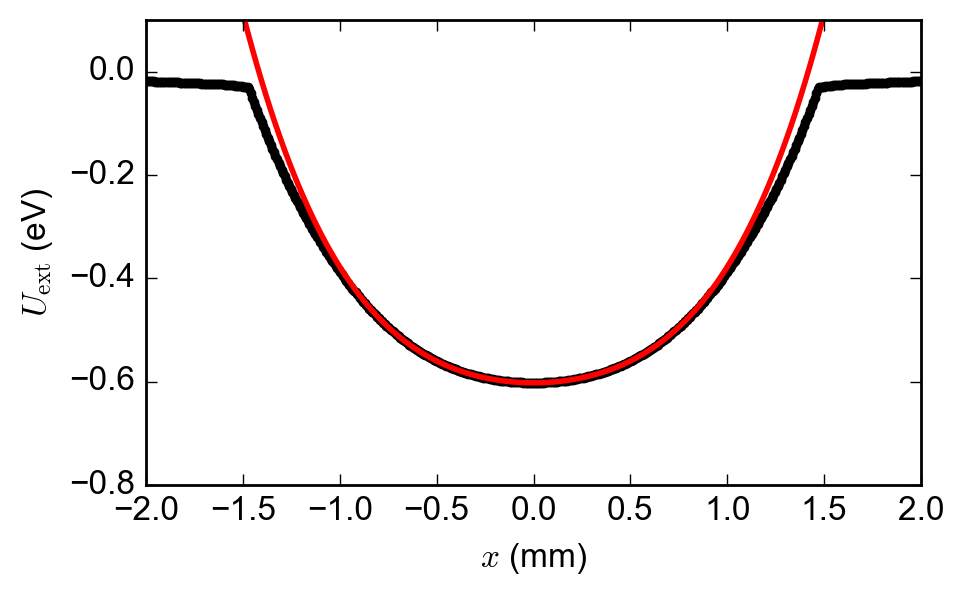

In [51]:
h = 0.74
fitdomain = (-0.75, 0.75)

xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)

x0 = -2.0 # Starting point for y
k = 251 # This defines the sampling
xeval = anneal.construct_symmetric_y(x0, k)

xinterp, yinterp, Uinterp = interpolate_slow.evaluate_on_grid(xdata, ydata, Udata, xeval=xeval, 
                                                     yeval=h, clim=(0.00, 1.00), plot_axes='xy', linestyle='None',
                                                     cmap=plt.cm.viridis, plot_data=False, 
                                                     **common.plot_opt("darkorange", msize=6))

# Mirror around the y-axis
xsize = len(Uinterp[0])
Uinterp_symmetric = np.zeros(2*xsize)
Uinterp_symmetric[:xsize] = Uinterp[0]
Uinterp_symmetric[xsize:] = Uinterp[0][::-1]

x_symmetric = np.zeros(2 * xsize)
x_symmetric[:xsize] = xinterp[0]
x_symmetric[xsize:] = -xinterp[0][::-1]

fig1 = plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(x_symmetric, -Uinterp_symmetric, '.k')
plt.ylim(-0.8, 0.1)
plt.xlim(-2, 2)
plt.ylabel("$U_{\mathrm{ext}}$ (eV)")
plt.xlabel("$x$ (mm)")

ax = plt.gca()
ax.set_axis_bgcolor('none')
fr, ferr = kfit.fit_poly(x_symmetric, -Uinterp_symmetric, mode='even', fitparams=[0, 1E4, 1E4], domain=fitdomain)
plt.plot(x_symmetric, kfit.polyfunc_even(x_symmetric, *fr), color='r', lw=2.0)

t = trap_analysis.TrapSolver()
t.get_electron_frequency([fr[0], -fr[1]/1E6], [ferr[0], -ferr[1]/1E6]);

The fit doesn't capture how there's two bumps in the potential, so in the end, I think we should still use the experimental data. This is not very hard, since we can just use the 1D interpolated data. Let us construct the interpolating function now.

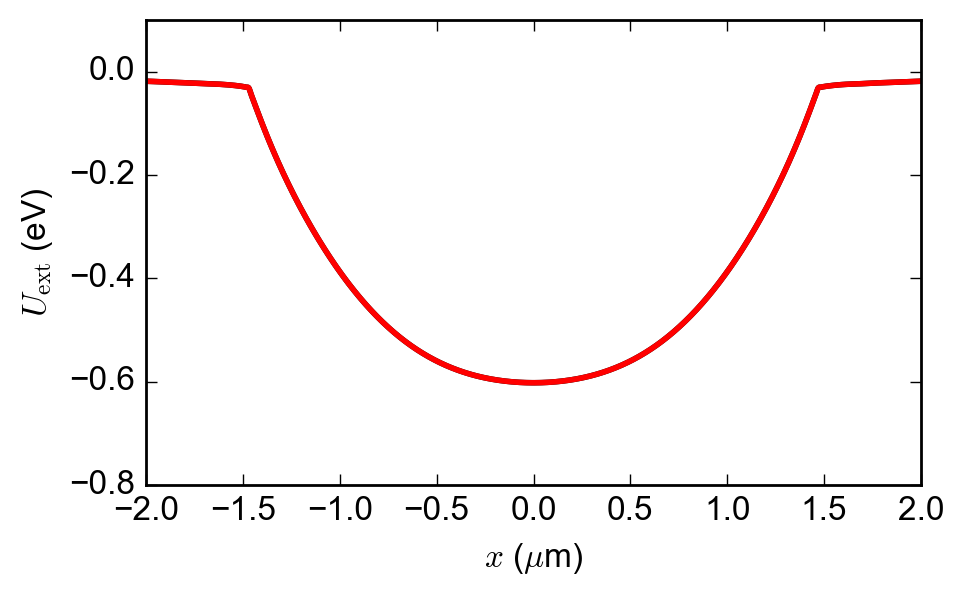

In [55]:
from scipy.interpolate import interp1d, UnivariateSpline
f = interp1d(x_symmetric * 1E-6, -Uinterp_symmetric, kind='cubic')
g = UnivariateSpline(x_symmetric * 1E-6, -Uinterp_symmetric, s=0)

x_test = np.linspace(-2E-6, 2E-6, 1E4)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(x_test*1E6, f(x_test), '-k', lw=2.0)
plt.plot(x_test*1E6, g(x_test), '-r', lw=2.0)
plt.plot(x_symmetric * 1E6, -Uinterp_symmetric, '.', color='gray')
plt.ylim(-0.8, 0.1)
plt.xlim(-2, 2)
plt.ylabel("$U_{\mathrm{ext}}$ (eV)")
plt.xlabel("$x$ ($\mu$m)")

Using `UnivariateSpline` we can also easily calculate the derivative in the $x$-direction. Something that is useful for evaluating the derivative.

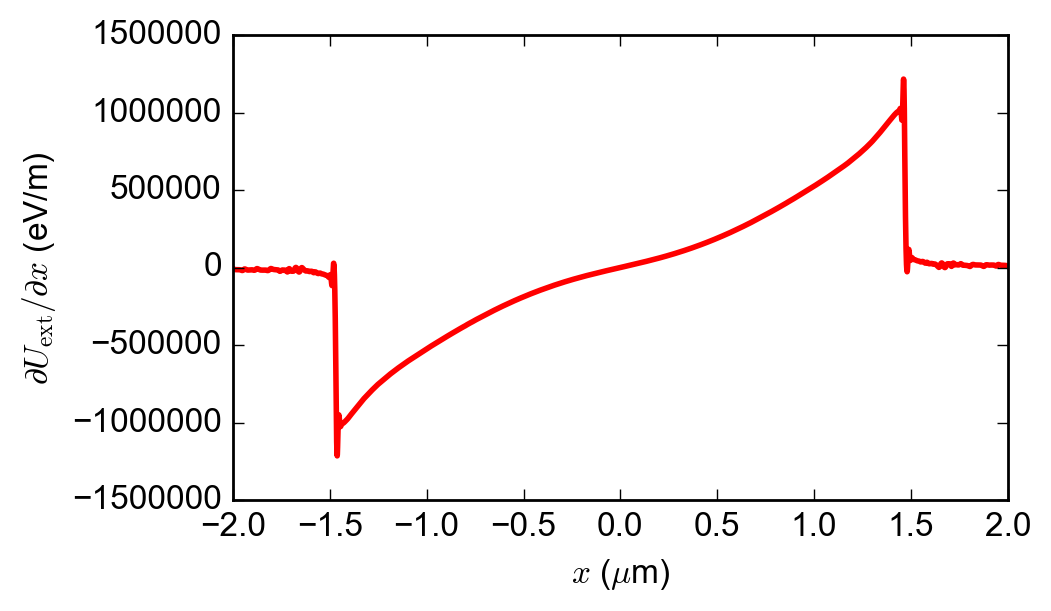

In [57]:
dgdx = g.derivative(n=1)

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(x_test*1E6, dgdx(x_test), '-r', lw=2.0)
#plt.ylim(-0.8, 0.1)
plt.xlim(-2, 2)
plt.ylabel("$\partial U_{\mathrm{ext}} / \partial x$ (eV/m)")
plt.xlabel("$x$ ($\mu$m)")

In [113]:
Vres = 0.36
EP = anneal.ResonatorSolver(x_symmetric * 1E-6, -Vres*Uinterp_symmetric, efield_data=None, 
                            box_length=40E-6, spline_order_x=3, smoothing=0.0,
                            include_screening=True, screening_length=2*h*1E-6)

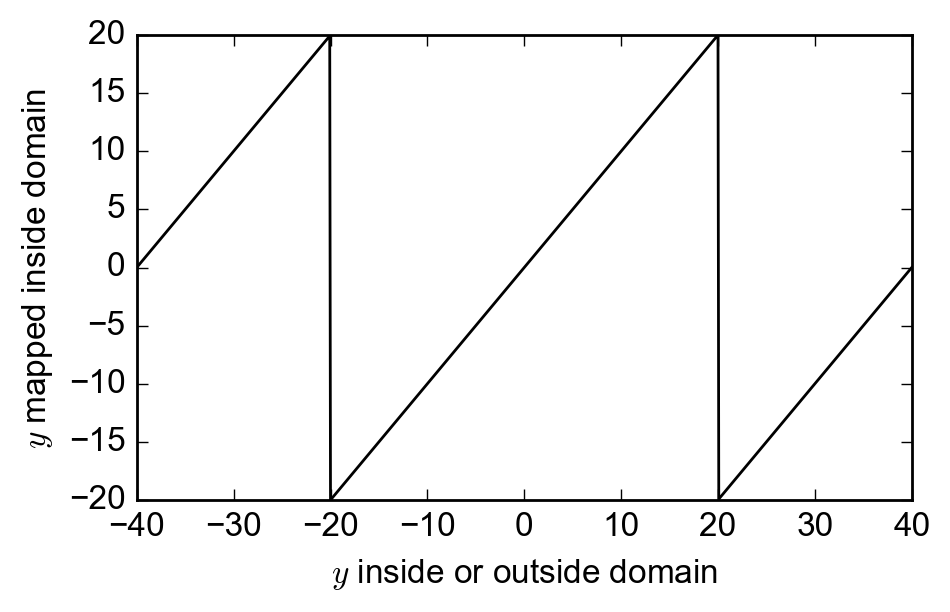

In [114]:
ytest = np.linspace(-40E-6, 40E-6, 1001)

plt.figure(figsize=(5.,3.))
plt.plot(ytest*1E6, EP.map_y_into_domain(ytest)*1E6, '-k')
plt.xlabel("$y$ inside or outside domain")
plt.ylabel("$y$ mapped inside domain")

In [115]:
N_electrons = 100

if 1: 
    # Rectangle
    N_cols = 25
    N_rows = 4
    if N_cols*N_rows != N_electrons:
        raise ValueError("N_cols and N_rows are not compatible with N_electrons")
    else:
        separation = 400E-9
        y0 = -15E-6
        ys = np.linspace(y0, y0+N_cols*separation, N_cols)
        yinit = np.tile(np.array(ys), N_rows)
        xs = np.linspace(-(N_rows-1)/2.*separation, +(N_rows-1)/2.*separation, N_rows)
        xinit = np.repeat(xs, N_cols)
if 0: 
    # Semi-circle
    initial_radius = 2.0E-6
    xinit = xeval[-1]*1E-6 + initial_radius*np.cos(2*np.pi * np.arange(0, N_electrons)/(2*N_electrons) + np.pi/2.)
    yinit = initial_radius*np.sin(2*np.pi * np.arange(0, N_electrons)/(2*N_electrons) + np.pi/2.)
if 0: 
    # Single line parallel to y
    x0 = 1E-6
    initial_span = 3E-6   
    xinit = x0 * np.ones(N_electrons)
    yinit = np.linspace(-initial_span/2., initial_span/2., N_electrons)

electron_initial_positions = anneal.xy2r(xinit, yinit)

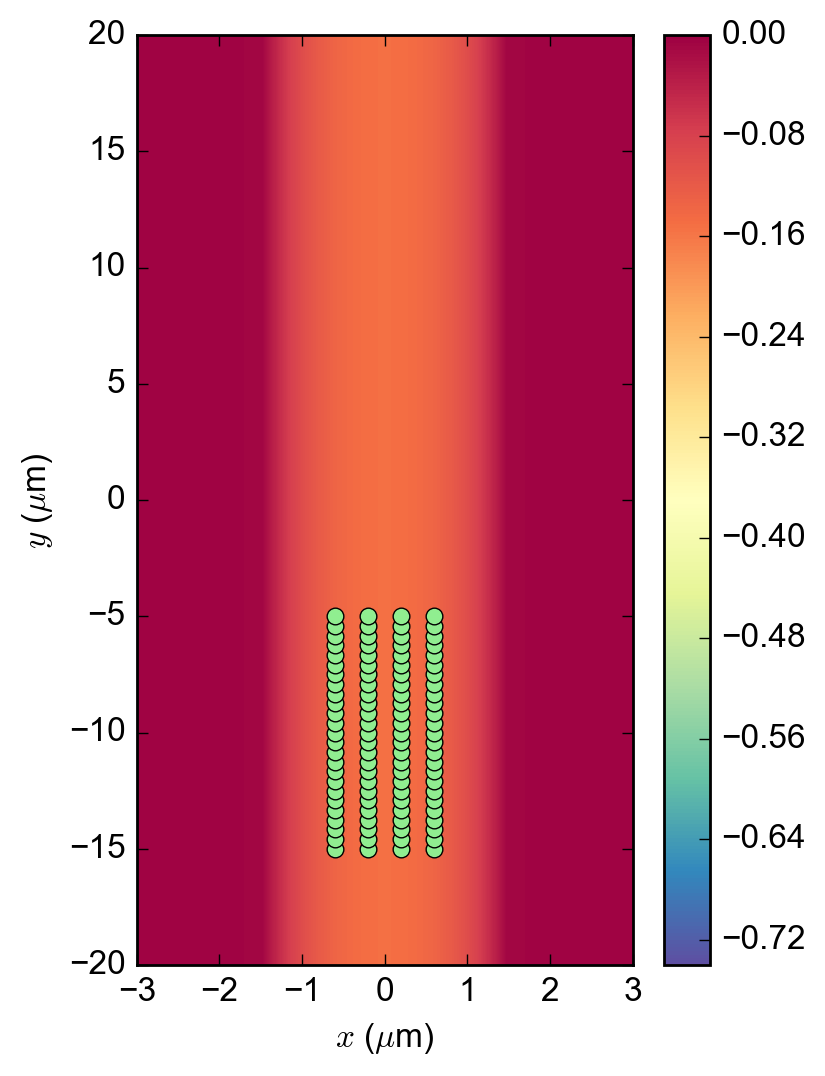

In [77]:
x_box = np.linspace(-3E-6, 3E-6, 501)
y_box = np.linspace(-20E-6, 20E-6, 21)

X_box, Y_box = np.meshgrid(x_box, y_box)

plt.figure(figsize=(4,6))
common.configure_axes(12)
plt.pcolormesh(x_box*1E6, y_box*1E6, EP.V(X_box, Y_box), cmap=plt.cm.Spectral_r, vmin=-0.74, vmax=0.00)
plt.plot(xinit*1E6, yinit*1E6, 'o', color='lightgreen')
plt.colorbar()
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")

## Tests and Timing

In [64]:
%timeit EP.Vtotal(electron_initial_positions)

1000 loops, best of 3: 851 µs per loop


In [65]:
%timeit EP.grad_total(electron_initial_positions)

100 loops, best of 3: 2.33 ms per loop


## Minimization

0	Uopt: -19.27080068 eV	Norm of gradient: 3.13e+04 eV/m
10	Uopt: -19.79352490 eV	Norm of gradient: 8.08e+04 eV/m
20	Uopt: -20.18418168 eV	Norm of gradient: 2.62e+04 eV/m
30	Uopt: -20.55333559 eV	Norm of gradient: 1.94e+04 eV/m
40	Uopt: -20.65136965 eV	Norm of gradient: 2.46e+04 eV/m
50	Uopt: -20.73167923 eV	Norm of gradient: 4.37e+03 eV/m
60	Uopt: -20.97932232 eV	Norm of gradient: 1.16e+04 eV/m
70	Uopt: -21.01750135 eV	Norm of gradient: 1.79e+04 eV/m
80	Uopt: -21.04783066 eV	Norm of gradient: 5.72e+03 eV/m
90	Uopt: -21.08224756 eV	Norm of gradient: 2.48e+03 eV/m
100	Uopt: -21.08987050 eV	Norm of gradient: 2.77e+03 eV/m
110	Uopt: -21.09702501 eV	Norm of gradient: 1.42e+03 eV/m
120	Uopt: -21.09930164 eV	Norm of gradient: 1.39e+03 eV/m
130	Uopt: -21.10025414 eV	Norm of gradient: 4.36e+02 eV/m
140	Uopt: -21.10055131 eV	Norm of gradient: 3.69e+02 eV/m
150	Uopt: -21.10067883 eV	Norm of gradient: 2.09e+02 eV/m
160	Uopt: -21.10073576 eV	Norm of gradient: 2.09e+02 eV/m
170	Uopt: -21.10075608 eV

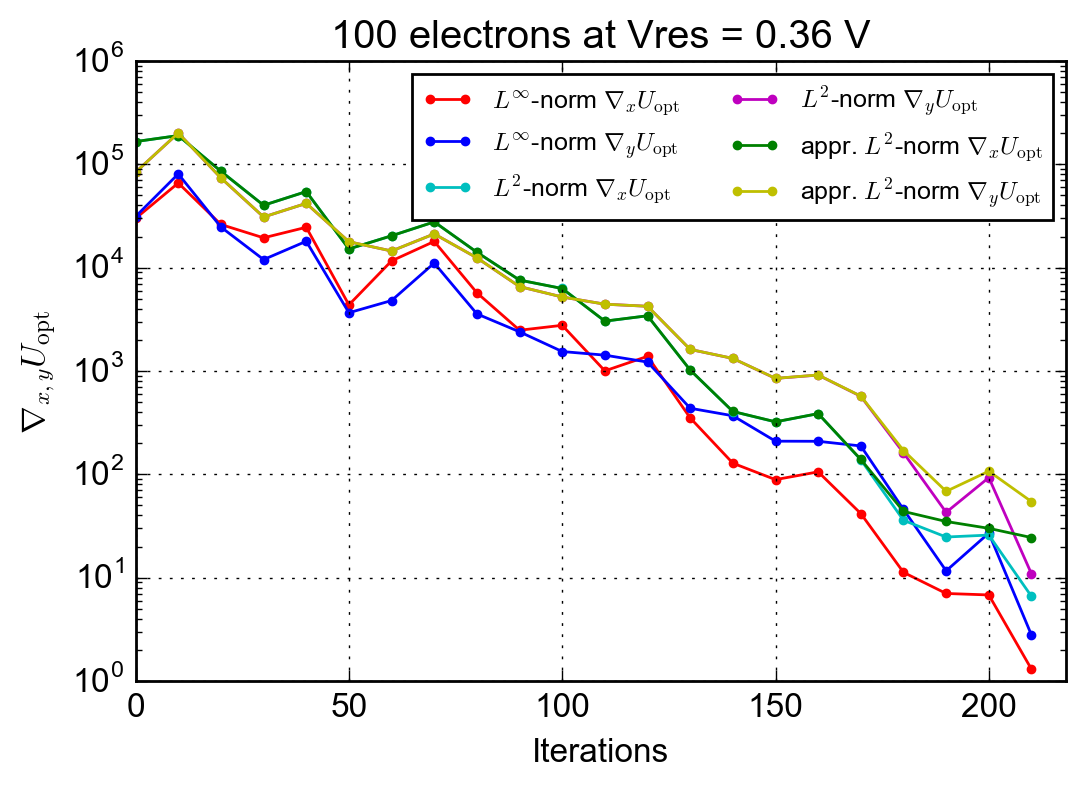

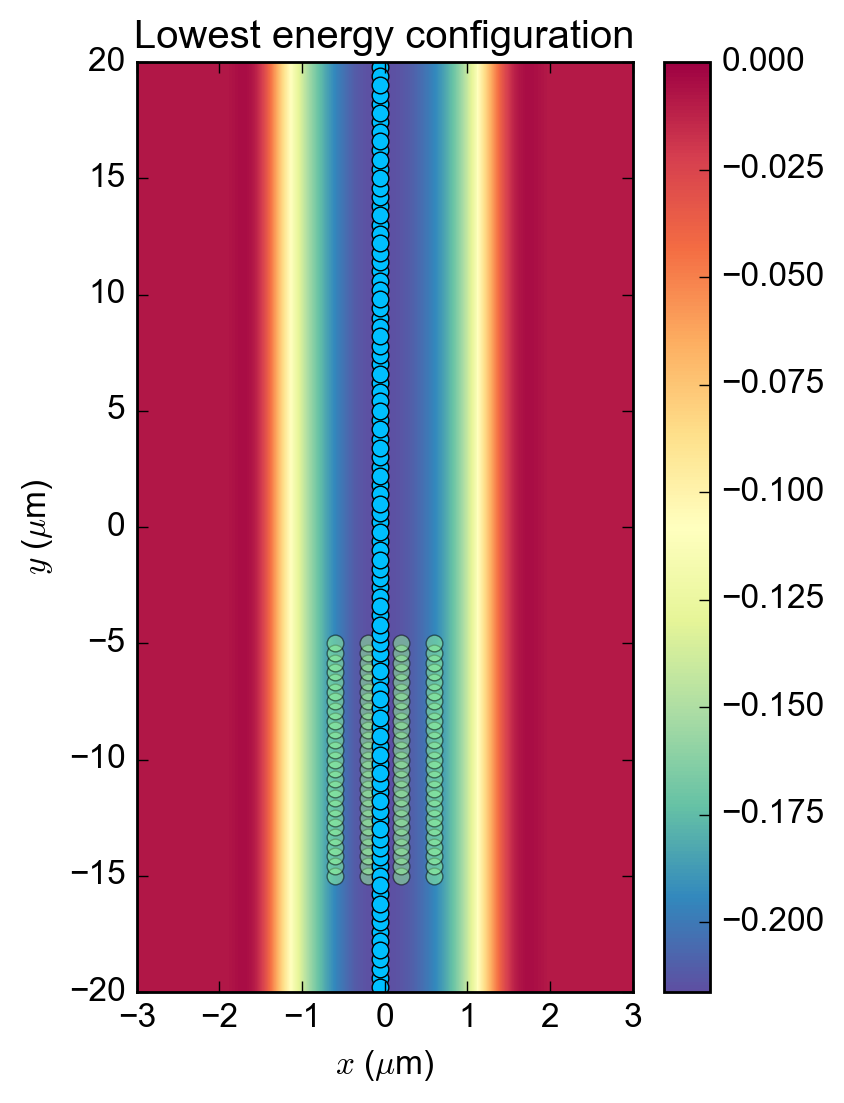

In [116]:
epsilon = 1e-10
use_gradient = True
annealing_steps = []
simulation_name = "resonator_perturbations_%d_electrons"%N_electrons
save_path = r"/Users/gkoolstra/Desktop/Electron optimization/Realistic potential/Resonator"
sub_dir = time.strftime("%y%m%d_%H%M%S_{}".format(simulation_name))
save = False
num_trapped_electrons = list()

if save: 
    os.mkdir(os.path.join(save_path, sub_dir))
    time.sleep(1)
    os.mkdir(os.path.join(save_path, sub_dir, "Figures"))

conv_mon_save_path = os.path.join(save_path, sub_dir, "Figures")

if use_gradient: 
    jac=EP.grad_total
    grad_Uopt = EP.grad_total
else:
    jac = None
    grad_Uopt = EP.grad_total#lambda x : approx_fprime(x, EP.Vtotal, epsilon)
    

ConvMon = anneal.ConvergenceMonitor(Uopt=EP.Vtotal, grad_Uopt=EP.grad_total, N=10, 
                                    Uext=EP.V, 
                                    xext=x_box, yext=y_box, verbose=True, eps=epsilon, 
                                    save_path=conv_mon_save_path, figsize=(4,6), 
                                    coordinate_transformation=EP.coordinate_transformation)

minimizer_options = {'jac': jac,
                     'options': {'disp': True, 'gtol': 1E0, 'eps': epsilon},
                     'callback': ConvMon.monitor_convergence}

res = minimize(EP.Vtotal, electron_initial_positions, method='CG', **minimizer_options)

#res = EP.perturb_and_solve(EP.Vtotal, len(annealing_steps), annealing_steps[0], res, 
#                          **minimizer_options)

if save: 
    # Create a movie
    ConvMon.create_movie(fps=20, 
                         filenames_in="%05d.png", 
                         filename_out="resonator_%d_electrons.mp4"%(N_electrons))

    # Move the file from the Figures folder to the sub folder
    os.rename(os.path.join(save_path, sub_dir, "Figures/resonator_%d_electrons.mp4"%(N_electrons)), \
              os.path.join(save_path, sub_dir, "resonator_%d_electrons.mp4"%(N_electrons)))

x, y = anneal.r2xy(res['x'])
final_func_val = res['fun']
n_iterations = res['nit']

%matplotlib inline
if len(np.shape(ConvMon.jac))>1:
    figgy = plt.figure(figsize=(6,4))
    common.configure_axes(12)
    # LInf-norm
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,::2]), axis=1), 
             '.-r', label=r'$L^\infty$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.amax(np.abs(ConvMon.jac[:,1::2]), axis=1), 
             '.-b', label=r'$L^\infty$-norm $\nabla_y U_\mathrm{opt}$')
    # L2-norm
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,::2])**2.0, axis=1)**(1/2.), 
             '.-c', label=r'$L^2$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.jac[:,1::2])**2.0, axis=1)**(1/2.), 
             '.-m', label=r'$L^2$-norm $\nabla_y U_\mathrm{opt}$')
    
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.approx_fprime[:,::2])**2.0, axis=1)**(1/2.), 
             '.-g', label=r'appr. $L^2$-norm $\nabla_x U_\mathrm{opt}$')
    plt.plot(ConvMon.iter, np.sum(np.abs(ConvMon.approx_fprime[:,1::2])**2.0, axis=1)**(1/2.), 
             '.-y', label=r'appr. $L^2$-norm $\nabla_y U_\mathrm{opt}$')
    
    plt.title("%d electrons at Vres = %.2f V"%(N_electrons, Vres))
        
    plt.xlabel("Iterations")
    plt.ylabel(r"$\nabla_{x,y} U_\mathrm{opt}$")
    plt.yscale('log')
    plt.xlim(0, res['nit'])
    plt.grid()
    plt.legend(loc=0, ncol=2, prop = {'size' : 9})

if save:
    common.save_figure(figgy, save_path=os.path.join(save_path, sub_dir))
    
y_in_domain = EP.map_y_into_domain(y)

figgy = plt.figure(figsize=(4,6))
common.configure_axes(12)
plt.title("Lowest energy configuration")
plt.pcolormesh(x_box*1E6, y_box*1E6, EP.V(X_box, Y_box), cmap=plt.cm.Spectral_r, vmax=0.0)
plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
plt.plot(x*1E6, y_in_domain*1E6, 'o', color='deepskyblue', alpha=1.0)
#plt.xlim(np.min(x_box*1E6), np.max(x_box*1E6))
#plt.ylim(np.min(y_box*1E6), np.max(y_box*1E6))
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
plt.colorbar()

if save:
    common.save_figure(figgy, save_path=os.path.join(save_path, sub_dir))

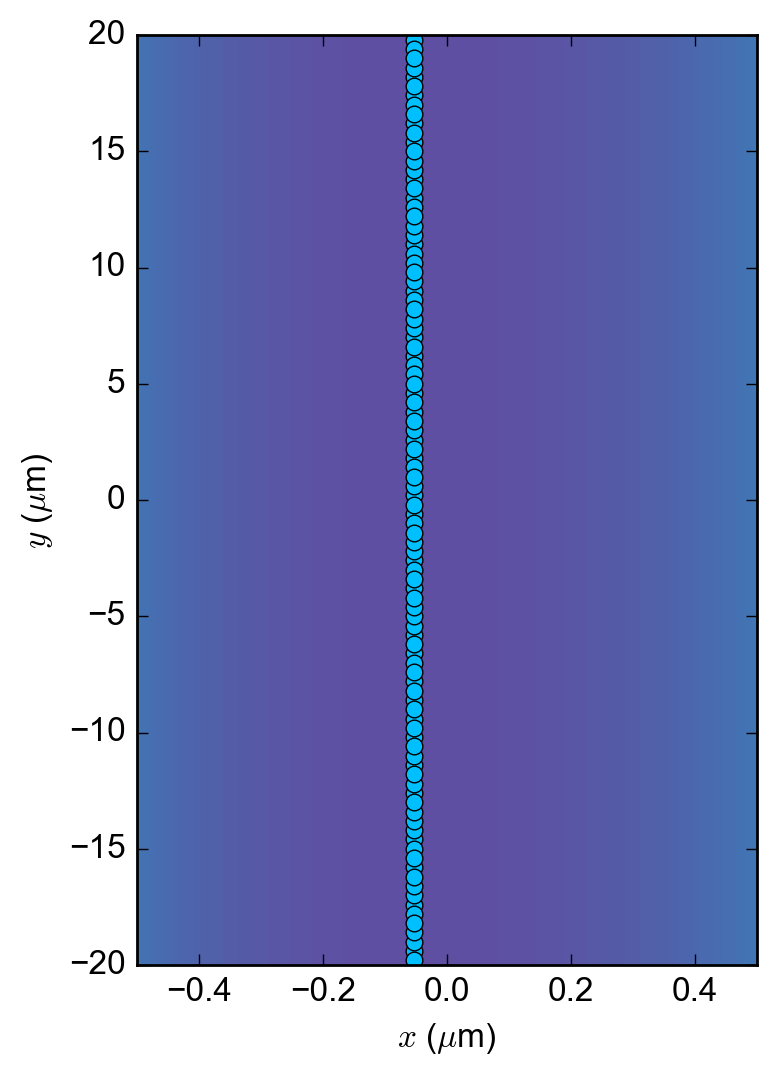

In [117]:
figgy = plt.figure(figsize=(4,6))
common.configure_axes(12)
plt.pcolormesh(x_box*1E6, y_box*1E6, EP.V(X_box, Y_box), cmap=plt.cm.Spectral_r, vmax=0.0)
#plt.plot(xinit*1E6, yinit*1E6, 'o', color='palegreen', alpha=0.5)
plt.plot(x*1E6, y_in_domain*1E6, 'o', color='deepskyblue', alpha=1.0)
#plt.xlim(np.min(x_box*1E6), np.max(x_box*1E6))
plt.xlim(-0.5, 0.5)
#plt.ylim(0,6)
plt.xlabel("$x$ ($\mu$m)")
plt.ylabel("$y$ ($\mu$m)")
#plt.gca().set_aspect('equal')